In [52]:
# Import Library
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import re
import requests
plt.style.use('bmh')

### Data Extraction

In [53]:
# Getting Yahoo finance data
def getdata(tickers, start, end, interval="1d"):
    data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval=interval,
        group_by="ticker",
        auto_adjust=False,
        progress=False
    )
    return data

tickers = ["CAT", "KMTUY"]

data = getdata(
    tickers,
    start="2018-01-01",
    end="2025-12-31",
    interval="1d"
)

CAT = data["CAT"]
KMTUY = data["KMTUY"]
print("Caterpillar Inc. Stock")
print(CAT)
print("\nKomatsu Stock")
print(KMTUY)

Caterpillar Inc. Stock
Price             Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  158.300003  159.389999  156.029999  157.039993  131.851608   
2018-01-03  157.039993  157.490005  155.399994  157.279999  132.053101   
2018-01-04  157.889999  159.580002  157.020004  159.440002  133.866669   
2018-01-05  160.259995  162.050003  159.639999  161.960007  135.982513   
2018-01-08  164.110001  166.429993  162.550003  166.029999  139.399719   
...                ...         ...         ...         ...         ...   
2025-12-23  580.500000  588.710022  580.500000  582.419983  582.419983   
2025-12-24  582.659973  587.130005  581.000000  583.760010  583.760010   
2025-12-26  583.210022  583.830017  578.650024  583.000000  583.000000   
2025-12-29  580.090027  583.969971  574.640015  578.609985  578.609985   
2025-12-30  580.010010  580.979980  575.510010  577.390015  577.390015   

Price        V

### Pairs Trading

In [54]:
pairs = pd.DataFrame({'CAT':CAT['Close'].shift(1)/CAT['Close'].shift(2)-1,
                      'KMTUY':KMTUY['Close'].shift(1)/KMTUY['Close'].shift(2)-1})

# Criteria to select which asset we're gonna buy, in this case, the one that had the lowest return yesterday
pairs['Target'] = pairs.min(axis=1)

# Signal that triggers the purchase of the asset
pairs['Correlation'] = ((CAT['Close'].shift(1)/CAT['Close'].shift(20)-1).rolling(window=9)
                        .corr((KMTUY['Close'].shift(1)/KMTUY['Close'].shift(20)-1)))

Signal = pairs['Correlation'] < 0.9

# We're holding positions that weren't profitable yesterday
HoldingYesterdayPosition = ((pairs['Target'].shift(1).isin(pairs['CAT']) &
                             (CAT['Close'].shift(1)/CAT['Open'].shift(1)-1 < 0)) |
                            (pairs['Target'].shift(1).isin(pairs['KMTUY']) &
                             (KMTUY['Close'].shift(1)/KMTUY['Open'].shift(1)-1 < 0))) # if tc, add here

# Since we aren't using leverage, we can't enter on a new position if
# we entered on a position yesterday (and if it wasn't profitable)
NoMoney = Signal.shift(1) & HoldingYesterdayPosition

pairs['CAT'] = np.where(NoMoney,
                        np.nan,
                        np.where(CAT['Close']/CAT['Open']-1 < 0,
                                 CAT['Close'].shift(-1)/CAT['Open']-1,
                                 CAT['Close']/CAT['Open']-1))

pairs['KMTUY'] = np.where(NoMoney,
                       np.nan,
                       np.where(KMTUY['Close']/KMTUY['Open']-1 < 0,
                                KMTUY['Close'].shift(-1)/KMTUY['Open']-1,
                                KMTUY['Close']/KMTUY['Open']-1))

pairs['Returns'] = np.where(Signal,
                            np.where(pairs['Target'].isin(pairs['CAT']),
                                      pairs['CAT'],
                                      pairs['KMTUY']),
                             np.nan) # if tc, add here

pairs['CumulativeReturn'] = pairs['Returns'].dropna().cumsum()
print(pairs)

                 CAT     KMTUY    Target  Correlation   Returns  \
Date                                                              
2018-01-02 -0.006443  0.008750       NaN          NaN       NaN   
2018-01-03  0.001528  0.013461       NaN          NaN       NaN   
2018-01-04  0.009817  0.005569  0.001528          NaN       NaN   
2018-01-05  0.010608  0.006093  0.013733          NaN       NaN   
2018-01-08  0.011699  0.019873  0.001582          NaN       NaN   
...              ...       ...       ...          ...       ...   
2025-12-23  0.003307 -0.004062  0.004077    -0.528286 -0.004062   
2025-12-24       NaN       NaN -0.005621    -0.492756       NaN   
2025-12-26 -0.007887  0.003152  0.000942    -0.222995  0.003152   
2025-12-29 -0.004654  0.021725 -0.001302     0.140015  0.021725   
2025-12-30       NaN       NaN -0.007530     0.356613       NaN   

            CumulativeReturn  
Date                          
2018-01-02               NaN  
2018-01-03               NaN  
2018

In [55]:
# Caterpillar Inc. returns
ReturnCAT = CAT['Close']/CAT['Open']-1
BuyHoldCAT = CAT['Adj Close']/float(CAT['Adj Close'][:1])-1

# Komatsu returns
ReturnKMTUY = KMTUY['Close']/KMTUY['Open']-1
BuyHoldKMTUY = KMTUY['Adj Close']/float(KMTUY['Adj Close'][:1])-1

# Benchmark
ReturnBoth = (ReturnCAT+ReturnKMTUY)/2
BuyHoldBoth = ((BuyHoldCAT+BuyHoldKMTUY)/2).fillna(method='ffill')
print("Caterpillar Inc. Return")
print(ReturnBoth)
print("\nKomatsu Return")
print(BuyHoldBoth)

Caterpillar Inc. Return
Date
2018-01-02   -0.006851
2018-01-03    0.007495
2018-01-04    0.007693
2018-01-05    0.008350
2018-01-08    0.015786
                ...   
2025-12-23   -0.000846
2025-12-24    0.020846
2025-12-26    0.001396
2025-12-29    0.009587
2025-12-30   -0.004126
Length: 2010, dtype: float64

Komatsu Return
Date
2018-01-02    0.000000
2018-01-03    0.008052
2018-01-04    0.029094
2018-01-05    0.037942
2018-01-08    0.057914
                ...   
2025-12-23    1.666847
2025-12-24    1.672360
2025-12-26    1.668903
2025-12-29    1.654414
2025-12-30    1.650219
Name: Adj Close, Length: 2010, dtype: float64


/tmp/ipython-input-3574971363.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  BuyHoldCAT = CAT['Adj Close']/float(CAT['Adj Close'][:1])-1
/tmp/ipython-input-3574971363.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  BuyHoldKMTUY = KMTUY['Adj Close']/float(KMTUY['Adj Close'][:1])-1
/tmp/ipython-input-3574971363.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BuyHoldBoth = ((BuyHoldCAT+BuyHoldKMTUY)/2).fillna(method='ffill')


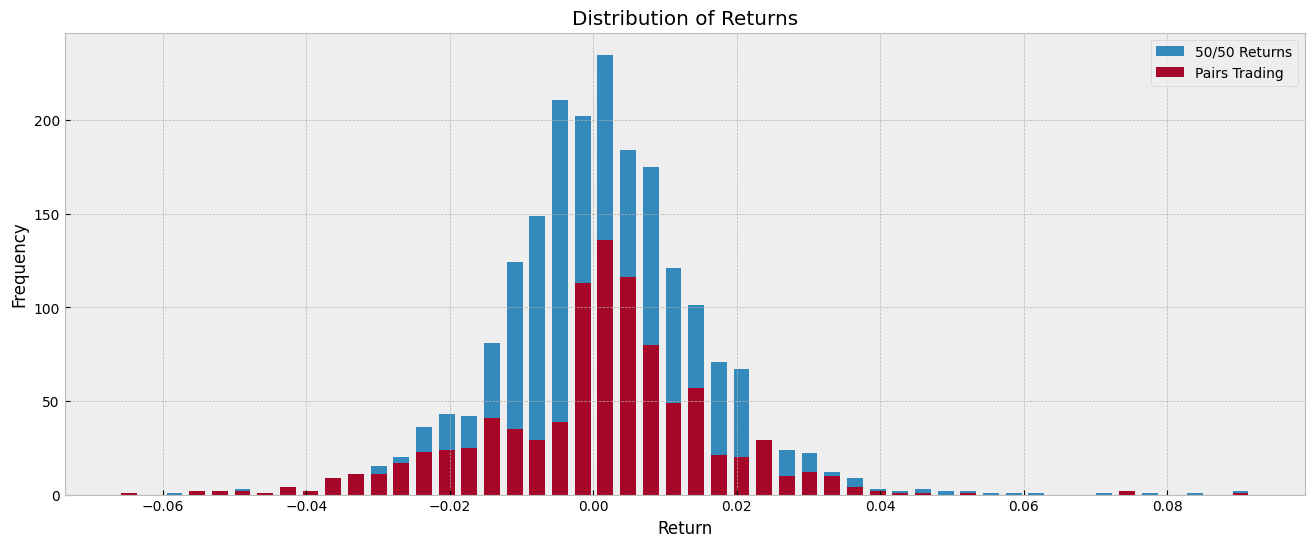

=====Strategy Returns=====
Mean return = 0.35 %
Standard deviaton = 2.23 %
Worst return = -8.92 %
Best return = 12.94 %
Lower quantile = -0.68 %
Median return = 0.5 %
Upper quantile = 1.5 %


In [56]:
returns = pairs['Returns'].dropna()
cumulret = pairs['CumulativeReturn'].dropna()

fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(ReturnBoth.dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

ax.bar(center, hist1, align='center', width=width, label='50/50 Returns')

hist2, bins2 = np.histogram(returns, bins=50)
ax.bar(center, hist2, align='center', width=width, label='Pairs Trading')

plt.legend()
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

print('=====Strategy Returns=====')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("==========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [57]:
# Some stats, this could be improved by trying to estimate a yearly sharpe, among many others
executionrate = len(returns)/len(ReturnBoth)

maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1)
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)
print("Execution rate = ",executionrate)
print("Maximum drawdown = ",maxdd,"%")
print("Worst drawdown = ",badd,"%")
print("Winrate = ",winrate,"%")
print("Beta = ",beta,"%")
print("Sharpe = ",sharpe,"%")
print("Tret = ",tret,"%")

Execution rate =  0.4691542288557214
Maximum drawdown =  30.14 %
Worst drawdown =  25.45 %
Winrate =  68.74 %
Beta =  0.74 %
Sharpe =  3.49 %
Tret =  328.08 %


/tmp/ipython-input-2476372746.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)
/tmp/ipython-input-2476372746.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tret = round((float(cumulret[-1:]))*100,2)


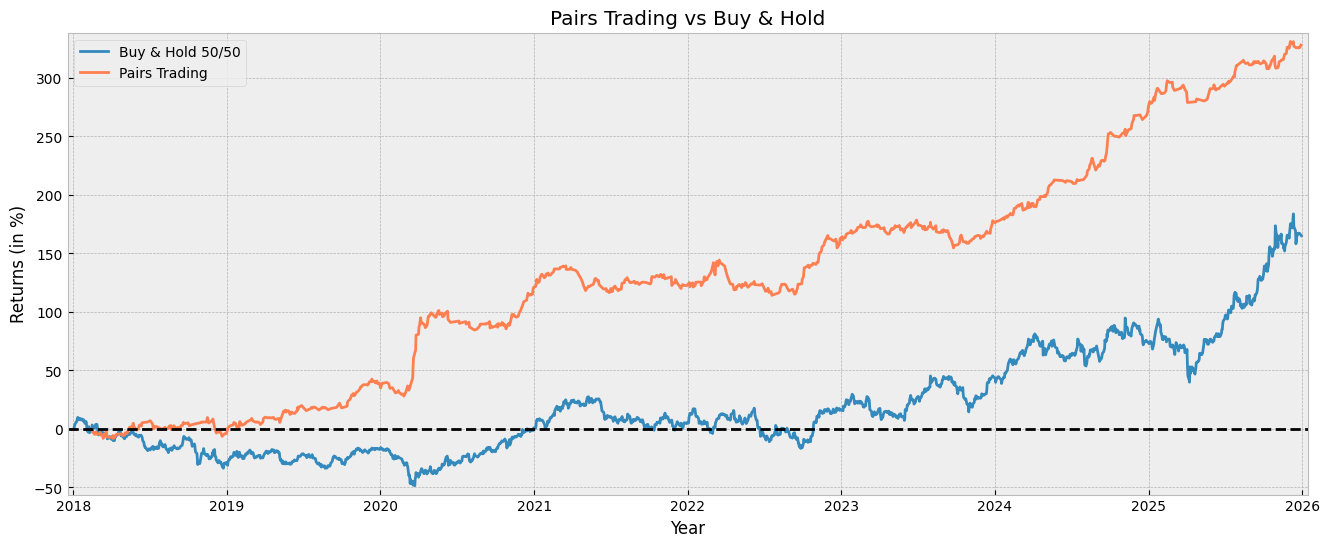

Cumulative Return =  328.08 %
Execution Rate =  46.92 %
Win Rate =  68.74 %
Maximum Loss =  30.14 %
Maximum Consecutive Loss =  25.45 %
Beta =  0.74
Sharpe =  3.49


In [58]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50')
plt.plot(cumulret*100, label='Pairs Trading', color='coral')
plt.xlabel('Year')
plt.ylabel('Returns (in %)')
plt.title('Pairs Trading vs Buy & Hold')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",round(executionrate*100,2),"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)
# Return ("alpha") decay is pretty noticeable from 2011 onwards, most likely due to overfitting, they're not reinvested

/tmp/ipython-input-408840398.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  BuyHoldBothYTD = (((CAT['Adj Close'][-252:]/float(CAT['Adj Close'][-252])-1)+(KMTUY['Adj Close'][-252:]/float(KMTUY['Adj Close'][-252])-1))/2).fillna(method='ffill')
/tmp/ipython-input-408840398.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BuyHoldBothYTD = (((CAT['Adj Close'][-252:]/float(CAT['Adj Close'][-252])-1)+(KMTUY['Adj Close'][-252:]/float(KMTUY['Adj Close'][-252])-1))/2).fillna(method='ffill')


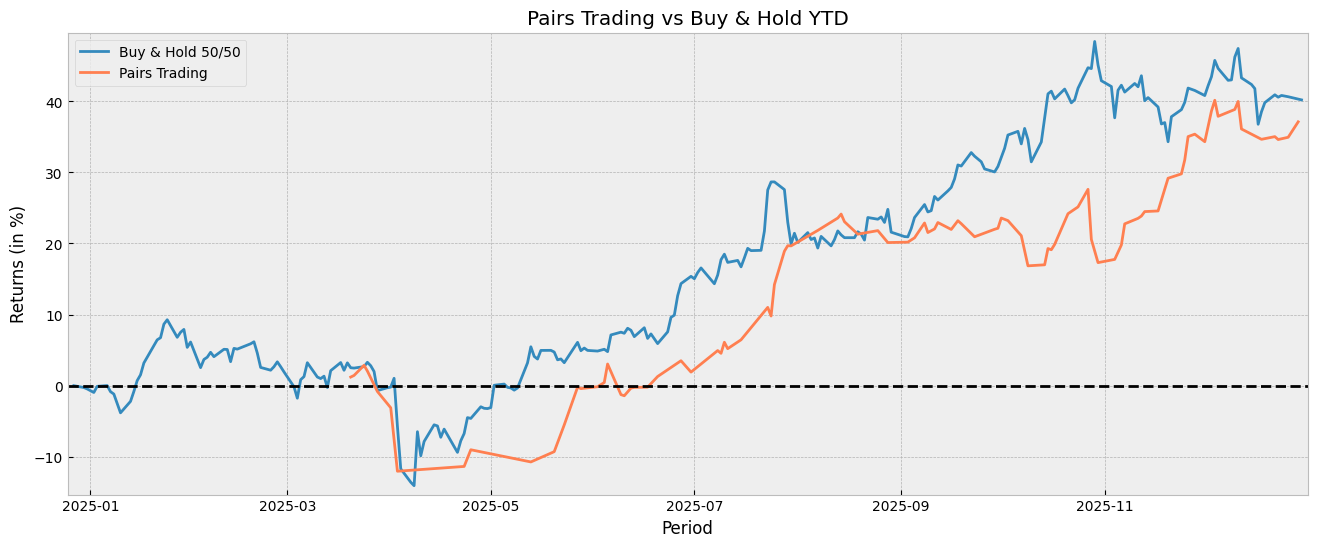

Buy & Hold 50/50 YTD Performance (at 1 July 2020) = 40.2 %
Strategy YTD Performance = 37.1 %


/tmp/ipython-input-408840398.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
/tmp/ipython-input-408840398.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')


In [59]:
BuyHoldBothYTD = (((CAT['Adj Close'][-252:]/float(CAT['Adj Close'][-252])-1)+(KMTUY['Adj Close'][-252:]/float(KMTUY['Adj Close'][-252])-1))/2).fillna(method='ffill')
StrategyYTD = returns[-92:].cumsum()

plt.figure(figsize=(16,6))
plt.plot(BuyHoldBothYTD*100, label='Buy & Hold 50/50')
plt.plot(StrategyYTD*100, label='Pairs Trading', color='coral')
plt.xlabel('Period')
plt.title('Pairs Trading vs Buy & Hold YTD')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')